In [1]:
import tensorflow as tf
import numpy as np
import DNA_reader as reader
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
class SmallConfig(object):
    """Small Configuration"""
    learning_rate = 1.0
    max_grad_norm = 3
    num_layers = 2
    num_steps_encoder = 10
    num_steps_decoder = 15
    batch_size = 10
    hidden_size = 200
    max_epochs = 2
    max_max_epochs = 5
    lr_decay = 0.5
    init_scale = 0.1
    vocab_size = 8 # 3 extra tokens PAD,GO and EOS and 0 is unused
    compression_dims = 2

def get_config(flag='small'):
    if flag=='small':
        return SmallConfig()

# Input and Model classes

In [3]:
def data_type():
    return tf.float32

class DNA_input(object):
    def __init__(self, config, data, name=None):
        self.batch_size = batch_size = config.batch_size
        self.num_steps_encoder = num_steps_encoder = config.num_steps_encoder
        self.num_steps_decoder = num_steps_decoder = config.num_steps_decoder
        self.epoch_size = len(data[0])//batch_size
        (self.encoder_input, self.decoder_input,
        self.decoder_targets, self.labels) = reader.DNA_producer(data, config, name)

class DNA_seq_model(object):
    def __init__(self, is_training, config, input_):
        self._input = input_
        batch_size = input_.batch_size
        num_steps_encoder = input_.num_steps_encoder
        num_steps_decoder = input_.num_steps_decoder
        num_layers = config.num_layers
        size = config.hidden_size
        vocab_size = config.vocab_size
        self._teacher_force = True
        compression_dims = config.compression_dims
        
#         weight_initializer = tf.random_normal_initializer(mean = 0.0, stddev=1.0)
        
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0, state_is_tuple=True)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=True)
        self._initial_state = cell.zero_state(batch_size, data_type())
        
#         lstm_cell_decoder = tf.nn.rnn_cell.BasicLSTMCell(size + compression_dims, forget_bias=0.0, state_is_tuple=True)
#         decoder_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell_decoder] * num_layers, state_is_tuple=True)
#         decoder_initial_state = decoder_cell.zero_state(batch_size, data_type())
        
        softmax_w = tf.get_variable("softmax_w", [size, vocab_size], dtype=data_type())
        softmax_b = tf.get_variable("softmax_b", [vocab_size], dtype=data_type())

        with tf.device("/cpu:0"):
            embedding = tf.get_variable(
                    "embedding", [vocab_size, size], dtype=data_type())
            encoder_inputs = tf.nn.embedding_lookup(embedding, input_.encoder_input)
            decoder_inputs = tf.nn.embedding_lookup(embedding, input_.decoder_input)
        
        
 
        
        encoder_outputs =[]
        state = self._initial_state
        with tf.variable_scope("RNN_encoder"):
            for time_step in range(num_steps_encoder):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                (cell_output, state) = cell(encoder_inputs[:, time_step, :], state)
                encoder_outputs.append(cell_output)
#         with tf.variable_scope("state_transform"):
        W_compress = tf.get_variable("W_compress", [2*num_layers*size, compression_dims], dtype=data_type())
        b_compress = tf.get_variable("bcompress", [compression_dims], dtype=data_type())
        W_sigma = tf.get_variable("W_sigma", [2*num_layers*size, compression_dims], dtype=data_type())
        b_sigma = tf.get_variable("b_sigma", [compression_dims], dtype=data_type())
        
#         W_expand = tf.get_variable("W_expand", [compression_dims,2*num_layers*size], dtype=data_type())
#         b_expand = tf.get_variable("b_expand", [2*num_layers*size], dtype=data_type())
        
        eps = tf.random_normal([compression_dims])
        
        self._encoded_state = state
        self.compressed_state = tf.reshape(tf.transpose(tf.pack(state),[0,1,3,2]),[-1,batch_size])
        self.compressed_state = tf.transpose(self.compressed_state,[1,0])
        
        mu = tf.matmul(self.compressed_state, W_compress) + b_compress
        log_sigma_sq = tf.matmul(self.compressed_state, W_sigma) + b_sigma
#         variance = sigma*sigma
        
        self._hidden_state = hidden_state = mu + tf.sqrt(tf.exp(log_sigma_sq)) * eps
        
        
#         self._hidden_state = hidden_state = tf.matmul(self.compressed_state, W_compress) + b_compress
#         expanded_state = tf.matmul(hidden_state, W_expand) + b_expand
#         expanded_state = tf.reshape(tf.transpose(expanded_state,[1,0]),[num_layers,2,size,-1])
#         expanded_state = tf.transpose(expanded_state,[0,1,3,2])
#         expanded_state = tf.unpack(expanded_state, axis=0)
#         state_list = []
#         for i,layer in enumerate(expanded_state):
#             state_list.append(tuple(tf.unpack(layer, axis=0)))
        
#         self.recovered_state = tuple(state_list)

#         expanded_state= self.recovered_state
        
        hidden_state = tf.tile(hidden_state,[num_steps_decoder,1])
        hidden_state = tf.reshape(hidden_state, [-1,num_steps_decoder, compression_dims])
        decoder_inputs = tf.concat(2, [decoder_inputs, hidden_state])
        W_decoder = tf.get_variable("W_decoder", [size + compression_dims, size], dtype=data_type())
        b_decoder = tf.get_variable("b_decoder", [size], dtype=data_type())
#         decoder_inputs = tf.batch_matmul(decoder_inputs, W_decoder)
        decoder_inputs_list = tf.unpack(decoder_inputs, axis=1)
#         decoder_inputs_list =[]
        for time_step in range(num_steps_decoder):
#             if time_step > 0:tf.get_variable_scope().reuse_variables()
            decoder_inputs_list[time_step] = tf.matmul(decoder_inputs_list[time_step], W_decoder) + b_decoder 
        
        def loop(prev, _):
            prev = tf.matmul(prev, softmax_w) + softmax_b
            prev_symbol = tf.stop_gradient(tf.argmax(prev, 1))
            true_symbol =  tf.nn.embedding_lookup(embedding, prev_symbol)
            appended_symbol = tf.concat(1, [true_symbol, self._hidden_state])
            final_symbol = tf.matmul(appended_symbol, W_decoder) +b_decoder
            return final_symbol
        
        (decoder_outputs, state) = tf.nn.seq2seq.rnn_decoder(decoder_inputs_list, self._initial_state, cell, 
                                                             loop_function=loop if not(self._teacher_force) else None)
        decoder_output = tf.reshape(tf.concat(1, decoder_outputs), [-1, size])

        logits = tf.matmul(decoder_output, softmax_w) + softmax_b
        self._probabilities = tf.reshape(tf.nn.softmax(logits), [batch_size, num_steps_decoder, vocab_size])
        
        loss = tf.nn.seq2seq.sequence_loss_by_example(
                [logits],
                [tf.reshape(input_.decoder_targets, [-1])],
                [tf.ones([batch_size * num_steps_decoder], dtype=data_type())])
#         KL_loss = 0.5 * (tf.reduce_sum(variance,1) + tf.reduce_sum(mu * mu,1) - compression_dims +tf.log(tf.reduce_prod(variance,1)) )
        KL_loss = 0.5 * tf.reduce_sum(tf.exp(log_sigma_sq)+tf.square(mu)-log_sigma_sq-1,1)
        self._KL_loss = KL_loss_avg = tf.reduce_sum(KL_loss)/ batch_size
        self._recon_loss = Reconstruction_loss_avg = tf.reduce_sum(loss) / batch_size
        self._anneal = tf.Variable(0.0, trainable=False)
        self._cost = cost = Reconstruction_loss_avg + self._anneal*KL_loss_avg
        self._decoded_state = state
        
        if not is_training:
            return

        self._lr = tf.Variable(0.0, trainable=False)
#         self._anneal = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),config.max_grad_norm)
        optimizer = tf.train.GradientDescentOptimizer(self._lr)
        global_step = tf.contrib.framework.get_or_create_global_step()
        self._train_op = optimizer.apply_gradients(
                zip(grads, tvars),
                global_step=global_step)

        self._new_lr = tf.placeholder(
                tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        self._new_anneal = tf.placeholder(
                tf.float32, shape=[], name='new_anneal')
        self._anneal_update = tf.assign(self._anneal, self._new_anneal)
    

    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})
    def assign_anneal(self, session, anneal_value):
        session.run(self._anneal_update, feed_dict={self._new_anneal: anneal_value})

    @property
    def input(self):
        return self._input

    @property
    def initial_state(self):
        return self._initial_state
    @property
    def encoded_state(self):
        return self._encoded_state

    @property
    def cost(self):
        return self._recon_loss

    @property
    def decoded_state(self):
        return self._decoded_state
    @property
    def hidden_state(self):
        return self._hidden_state

    @property
    def lr(self):
        return self._lr
    @property
    def anneal(self):
        return self._anneal

    @property
    def train_op(self):
        return self._train_op
    @property
    def probabilities(self):
        return self._probabilities
    @property
    def KL_loss(self):
        return self._KL_loss
    @property
    def recon_loss(self):
        return self._recon_loss
    



In [4]:
def run_epoch(session, model, eval_op=None, verbose=False, supervisor=None):
    """Run the model for a single epoch"""
    start_time=time.time()
    costs = 0.0
    iters = 0
    state = session.run(model.initial_state)
    
    fetches = {
        "cost": model.cost,
        "encoded_state": model.encoded_state,
        "KL_loss": model.KL_loss
    }
    if eval_op is not None:
        fetches["eval_op"] = eval_op
    for step in range(model.input.epoch_size):
        feed_dict={}
        for i, (c,h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        vals = session.run(fetches, feed_dict)
        if supervisor:
            supervisor.summary_computed(session, session.run(supervisor.summary_op))
        cost = vals["cost"]
#         state = vals["encoded_state"]
        costs += cost
        iters += model.input.num_steps_decoder
        
        if verbose and step % (model.input.epoch_size //10) ==10:
            print("%.3f perplexity: %.3f KL Loss: %.3f speed %.0f nps" %
                 (step * 1.0/model.input.epoch_size, np.exp(costs / iters),
                  vals["KL_loss"],
                 iters * model.input.batch_size /(time.time()-start_time)))
    return np.exp(costs / iters)

In [5]:
def visualize_states(session, model, config, epoch=0):
    state = session.run(model.initial_state)
    fetches = {
        "hidden_state" : model.hidden_state,
        "labels" : model.input.labels,
    }
    batch_size = model.input.batch_size
    epoch_size = model.input.epoch_size
    hidden_state = np.zeros([model.input.epoch_size*model.input.batch_size, config.compression_dims])
    labels = np.zeros([model.input.epoch_size*model.input.batch_size])
    for step in range(model.input.epoch_size):
        feed_dict={}
        for i, (c,h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        vals = session.run(fetches, feed_dict)
        hidden_state[step*batch_size:(step+1)*batch_size] = vals["hidden_state"]
        labels[step*batch_size:(step+1)*batch_size] = vals["labels"]
    x_hidden = hidden_state[:,0]
    x_max = np.max(abs(x_hidden))
    x_hidden = (x_hidden / x_max) * 100
    y_hidden = hidden_state[:,1]
    y_max = np.max(abs(y_hidden))
    y_hidden = (y_hidden / y_max) * 100
    plt.figure(0)
    plt.scatter(x_hidden, y_hidden, s=20, c=labels)
    plt.title('Hidden States of system')
    plt.savefig('test2/model/states'+str(epoch))
    return x_hidden, y_hidden, labels
        
    

In [6]:
def visualize_samples(session, model, config):
    state = session.run(model.initial_state)
    model._teacher_force = False
    fetches = {
        "probabilities" : model.probabilities,
        "input" :model.input.encoder_input,
        "cost" :model.cost
    }
    batch_size = model.input.batch_size
    epoch_size = model.input.epoch_size
    num_steps_decoder = config.num_steps_decoder
    inputs = []
    outputs = []
    epoch_size = model.input.epoch_size
    epoch_size = 2
    for step in range(epoch_size):
        feed_dict = {}
        for i, (c,h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        vals = session.run(fetches, feed_dict)
        probs = vals["probabilities"]
        print("Batch perplexity: %.3f" %
                 (np.exp(vals["cost"] / model.input.num_steps_decoder)))
        input_list = vals["input"].tolist()
        for seq in input_list:
            inputs.append(num_to_string(seq))
#         inputs.append(vals["input"].tolist())
        
        for i in range(batch_size):
            seq = []
            for j in range(num_steps_decoder):
                char = np.random.multinomial(1, probs[i, j]/(np.sum(probs[i,j])+1e-5))
                char = np.argmax(char)
                seq.append(char)
#                 print(probs[i,j])
            outputs.append(num_to_string(seq))
    for i in range(len(inputs)):
        print("%s\t\t%s"%(inputs[i],outputs[i]))
#     print("Outputs")
#     print(outputs)
        
            

In [7]:
def num_to_string(num_list):
    string_list = []
    char_dict = {0:'A',1:'G',2:'C',3:'T',4:' ',5:'|',6:' ',7:' '}    
    for num in num_list:
        if num == 6:
            break
        char = char_dict[num]
        string_list.append(char)
    if not string_list:
        string_list.append(' ')
    return ''.join(string_list)

# Data generation

In [8]:
data_size = 10000
seq_length = 10
raw_data=reader.DNA_read(data_size,seq_length)

# Training

Epoch: 1 Learning rate: 1.000 Anneal: 0.000
0.010 perplexity: 8.262 KL Loss: 12.003 speed 576 nps
0.110 perplexity: 5.347 KL Loss: 9.112 speed 2079 nps
0.210 perplexity: 3.472 KL Loss: 9.313 speed 2554 nps
0.310 perplexity: 2.620 KL Loss: 17.897 speed 2780 nps
0.410 perplexity: 2.259 KL Loss: 52.088 speed 2929 nps
0.510 perplexity: 2.074 KL Loss: 219274544.000 speed 2959 nps
0.610 perplexity: 1.994 KL Loss: 56308510720.000 speed 3017 nps
0.710 perplexity: 2.009 KL Loss: 687238522339328.000 speed 3044 nps
0.810 perplexity: 1.990 KL Loss: 4202651189248.000 speed 3081 nps
0.910 perplexity: 1.982 KL Loss: 5179738255557394432.000 speed 3101 nps
Epoch: 1 Train Perplexity: 1.963
1000
Epoch: 2 Learning rate: 1.000 Anneal: 0.250
0.010 perplexity: 1.409 KL Loss: 2.445 speed 3646 nps
0.110 perplexity: 1.327 KL Loss: 0.008 speed 3404 nps
0.210 perplexity: 1.311 KL Loss: 0.027 speed 3409 nps
0.310 perplexity: 1.300 KL Loss: 0.007 speed 3462 nps
0.410 perplexity: 1.293 KL Loss: 0.003 speed 3513 nps


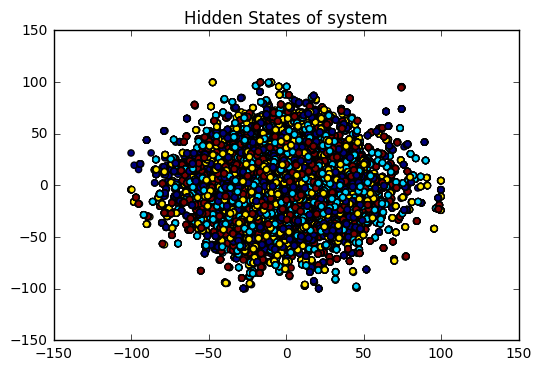

In [9]:
config = get_config()
save_path = 'test2/model'
testing =True
with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-config.init_scale,
                                               config.init_scale)
    with tf.name_scope("Train"):
        train_input = DNA_input(config, raw_data, "TrainInput")
        with tf.variable_scope("Model", reuse=None, initializer=initializer):
            m = DNA_seq_model(is_training=True, config=config, input_=train_input)
        tf.scalar_summary("Training Loss", m.cost)
        tf.scalar_summary("Learning Rate", m.lr)
        tf.scalar_summary("KL Loss", m.KL_loss)
        tf.scalar_summary("Reconstruction Loss", m.recon_loss)
        tf.histogram_summary("Probabilities", m.probabilities)
        tf.histogram_summary("Hidden_state", m.hidden_state)
    sv = tf.train.Supervisor(logdir= save_path, init_op = tf.initialize_all_variables())
    with sv.managed_session() as session:
        for i in range(config.max_max_epochs):
            lr_decay = config.lr_decay ** max(i+1-config.max_epochs, 0.0)
            anneal = (1/(float(config.max_max_epochs-1))) * i
            m.assign_anneal(session, anneal)
            m.assign_lr(session, config.learning_rate * lr_decay)
#             print(session.run(m.recovered_state[0]).shape)
            print("Epoch: %d Learning rate: %.3f Anneal: %.3f" % (i + 1, session.run(m.lr), session.run(m.anneal)))
            train_perplexity = run_epoch(session, m, eval_op=m.train_op,
                                         verbose=True, supervisor=sv)
            sv.summary_computed(session,session.run(sv.summary_op))
            print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
            print(sv.global_step.eval(session=session))
            x,y,l = visualize_states(session, m, config,i+1)
#         visualize_samples(session, m, config)
    
        if save_path:
#             print("Saving model to %s." % save_path)
            last_step = (sv.global_step.eval(session=session))
            print(last_step)
            saving = sv.saver.save(session, save_path, global_step = last_step)
            print("Saving model to %s." % saving)
#             sv.saver.save(session, save_path)
            
        if save_path and testing:
            ckpt = tf.train.get_checkpoint_state('test2')
            sv.saver.restore(session, ckpt.model_checkpoint_path)
            print("Loading model from %s." % ckpt.model_checkpoint_path)
            print(sv.global_step.eval(session=session))
            x,y,l = visualize_states(session, m, config)
            visualize_samples(session, m, config)
        
            

In [10]:
(1/(float(config.max_max_epochs)-1))

0.25

In [11]:
# sv = tf.train.Supervisor(logdir='test2')
# # with sv.managed_session() as session:
#     visualize_samples(session, m, config)
# #     b = x2.eval(session=session)
# #     c = x3.eval(session=session)

In [12]:
a=(1,2)
b=(a[0]*1)